##1. Завантаження даних

In [1]:
# Завантаження файлу (використовуємо твір "Лис Микита" Івана Франка)
from google.colab import files

uploaded = files.upload()

Saving Lys_mykyta.txt to Lys_mykyta.txt


In [2]:
# Зчитування тексту
with open("Lys_mykyta.txt", 'r', encoding='utf-8') as f:
    text = f.read()

# Виведемо приклад
print("Перші 1000 символів тексту:")
print(text[:1000])

Перші 1000 символів тексту:
Казка.укр - дитячі книги з малюнками 
українською мовою онлайн
Іван Франко
Лис Микита
За редакцією Максима Рильского
Ілюстрації – С.Артюшенко


Пісня перша
Надійшла весна прекрасна,
Многоцвітна, тепла, ясна,
Мов дівчина у вінку;
Ожили луги, діброви,
Повно гамору, розмови
І пісень в чагарнику.

Лев, що цар є над звірами,
Пише листи з печатками,
Розсилає на весь світ:
В тих листах велить він строго,
Щоб посходився до нього
В мить увесь звірячий рід.

Ось ідуть вони юрбами –
Ті безхвості, ті з хвостами.
Все, що виє, гавка, квака;
Лиш один мов і не чує,
В своїм замку, знай, ночує –
Лис Микита, розбишака.

Ой, недаром він сховався!
Певне, слухать побоявся,
Що звірячий скаже люд.
А тим часом у столиці
Цар засів біля цариці,
Щоб творити звірам суд.

Перший вийшов Вовк Неситий:
– Царю, – каже, – від Микити
Вже мені хоч пропадать!
Діток моїх б'є, кусає,
А Вовчицю обмовляє
Так, що й сором повідать!

А й мене – хіба ж то чесно? –
Як він хитро і облесно
Мало в гріб раз 

In [3]:
# Обрахунок загальної довжини
total_chars = len(text)
unique_chars = len(set(text))

print(f"Всього символів у тексті: {total_chars}")
print(f"Унікальних символів: {unique_chars}")

Всього символів у тексті: 86526
Унікальних символів: 80


##2. Очищення та токенізація

In [4]:
import re
import torch
from transformers import XLMRobertaTokenizer

# 1. Очищення тексту
cleaned_text = re.sub(r'[^а-яєґії\s]', ' ', text.lower())
cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

# 2. Ініціалізація токенізатора
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# 3. Токенізація
tokenized = tokenizer(cleaned_text, return_tensors="pt", add_special_tokens=False)["input_ids"].squeeze()

# 4. Побудова пар X -> y
seq_length = 64
inputs, targets = [], []

for i in range(len(tokenized) - seq_length):
    inputs.append(tokenized[i:i+seq_length])
    targets.append(tokenized[i+1:i+1+seq_length])

# 5. Перетворення в тензори
inputs = torch.stack(inputs)
targets = torch.stack(targets)

print(f"Кількість токенізованих пар: {len(inputs)}")
print(f"Форма прикладу: {inputs[0].shape} → {targets[0].shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (25256 > 512). Running this sequence through the model will result in indexing errors


Кількість токенізованих пар: 25192
Форма прикладу: torch.Size([64]) → torch.Size([64])


##3. Побудова моделі

In [5]:
import torch.nn as nn
from transformers import XLMRobertaModel

class TransformerGenerator(nn.Module):
    def __init__(self, hidden_dim, vocab_size, num_layers=2, nhead=8):
        super().__init__()
        self.encoder = XLMRobertaModel.from_pretrained("xlm-roberta-base")
        self.encoder.requires_grad_(False)

        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.output_fc = nn.Linear(hidden_dim, vocab_size)

        self.hidden_dim = hidden_dim

    def forward(self, input_ids, target_ids):
        # Encoder: отримуємо контекстні ембеддинги з XLM-RoBERTa
        with torch.no_grad():
            encoder_out = self.encoder(input_ids).last_hidden_state.transpose(0, 1)  # [seq, batch, hidden]

        # Decoder: teacher forcing (використовуємо target як вхід)
        tgt_emb = self.embedding(target_ids).transpose(0, 1)  # [seq, batch, hidden]

        tgt_seq_len = target_ids.shape[1]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(input_ids.device)

        decoder_out = self.transformer_decoder(tgt=tgt_emb, memory=encoder_out, tgt_mask=tgt_mask)
        logits = self.output_fc(decoder_out.transpose(0, 1))  # [batch, seq, vocab]

        return logits

In [6]:
from torch.utils.data import Dataset, DataLoader

class TransformerDataset(Dataset):
    def __init__(self, input_ids, target_ids):
        self.inputs = input_ids
        self.targets = target_ids

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_seq = self.inputs[idx]
        target_seq = self.targets[idx]
        return input_seq, target_seq[:-1], target_seq[1:]  # (X, y_in, y_out)

In [7]:
transformer_dataset = TransformerDataset(inputs, targets)
transformer_loader = DataLoader(transformer_dataset, batch_size=16, shuffle=True)

##4. Ініціалізація моделі, оптимізатора і функції втрат

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)

# Створюємо модель
model = TransformerGenerator(hidden_dim=256, vocab_size=tokenizer.vocab_size).to(device)

# Оптимізатор і функція втрат
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()

Використовується пристрій: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

##5. Тренування моделі

In [11]:
import torch
from tqdm import tqdm
import numpy as np

# Параметри
EPOCHS = 25
PATIENCE = 4
lr = 3e-4
hidden_dim = 768  # має співпадати з XLM-RoBERTa hidden size (зустрічалась помилка раніше)

# Ініціалізація
model = TransformerGenerator(
    hidden_dim=hidden_dim,
    vocab_size=tokenizer.vocab_size,
    num_layers=2,
    nhead=8
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Early stopping
best_loss = float("inf")
epochs_no_improve = 0
losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for input_ids, decoder_in, decoder_out in tqdm(transformer_loader, desc=f"Epoch {epoch+1}"):
        input_ids = input_ids.to(device)
        decoder_in = decoder_in.to(device)
        decoder_out = decoder_out.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, decoder_in)  # [batch, seq, vocab]
        loss = criterion(logits.view(-1, logits.size(-1)), decoder_out.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(transformer_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} — Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_transformer.pt")
        print("Модель збережено")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping — модель не покращується")
            break

Epoch 1: 100%|██████████| 1575/1575 [03:12<00:00,  8.16it/s]


Epoch 1 — Loss: 1.4945
Модель збережено


Epoch 2: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 2 — Loss: 0.1606
Модель збережено


Epoch 3: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 3 — Loss: 0.0975
Модель збережено


Epoch 4: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 4 — Loss: 0.0678
Модель збережено


Epoch 5: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 5 — Loss: 0.0517
Модель збережено


Epoch 6: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 6 — Loss: 0.0447
Модель збережено


Epoch 7: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 7 — Loss: 0.0395
Модель збережено


Epoch 8: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 8 — Loss: 0.0361
Модель збережено


Epoch 9: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 9 — Loss: 0.0344
Модель збережено


Epoch 10: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 10 — Loss: 0.0307
Модель збережено


Epoch 11: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 11 — Loss: 0.0309


Epoch 12: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 12 — Loss: 0.0284
Модель збережено


Epoch 13: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 13 — Loss: 0.0274
Модель збережено


Epoch 14: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 14 — Loss: 0.0263
Модель збережено


Epoch 15: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 15 — Loss: 0.0261
Модель збережено


Epoch 16: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 16 — Loss: 0.0255
Модель збережено


Epoch 17: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 17 — Loss: 0.0239
Модель збережено


Epoch 18: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 18 — Loss: 0.0240


Epoch 19: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 19 — Loss: 0.0233
Модель збережено


Epoch 20: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 20 — Loss: 0.0227
Модель збережено


Epoch 21: 100%|██████████| 1575/1575 [03:12<00:00,  8.19it/s]


Epoch 21 — Loss: 0.0227


Epoch 22: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 22 — Loss: 0.0217
Модель збережено


Epoch 23: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 23 — Loss: 0.0211
Модель збережено


Epoch 24: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]


Epoch 24 — Loss: 0.0209
Модель збережено


Epoch 25: 100%|██████████| 1575/1575 [03:12<00:00,  8.20it/s]

Epoch 25 — Loss: 0.0215


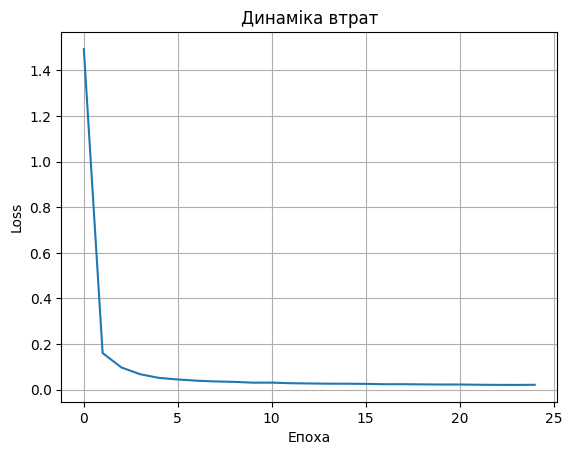

In [12]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Динаміка втрат")
plt.xlabel("Епоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

##6. Перевіряємо результат

In [13]:
# Завантаження збереженої моделі
model.load_state_dict(torch.load("best_transformer.pt"))
model.eval()

TransformerGenerator(
  (encoder): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)

In [14]:
def generate_text_transformer(seed_text, length=50, temperature=1.0):
    model.eval()

    # Токенізуємо seed
    input_ids = tokenizer(seed_text, return_tensors="pt", add_special_tokens=False)["input_ids"].to(device)

    generated_ids = input_ids.clone()

    for _ in range(length):
        # Отримуємо encoder output з XLM-RoBERTa
        with torch.no_grad():
            encoder_out = model.encoder(generated_ids).last_hidden_state.transpose(0, 1)  # [seq_len, batch, hidden]

        # Decoder input (shifted right)
        tgt_input = model.embedding(generated_ids).transpose(0, 1)  # [seq_len, batch, hidden]

        # Casual mask
        seq_len = tgt_input.size(0)
        casual_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(device)

        # Прогін через decoder
        with torch.no_grad():
            decoded = model.transformer_decoder(tgt_input, encoder_out, tgt_mask=casual_mask)
            logits = model.output_fc(decoded[-1])  # беремо тільки останній токен [batch, vocab_size]

        # Sampling (temperature)
        logits = logits / temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Додаємо новий токен
        generated_ids = torch.cat([generated_ids, next_token], dim=1)

        # Обмежуємо довжину до 512 (якщо потрібно)
        if generated_ids.size(1) > 512:
            generated_ids = generated_ids[:, -512:]

    return tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)

In [30]:
print(generate_text_transformer("Сонце", length=100, temperature=1.1))

Сонце ти проклятий смієш гордо виступати грізно з трону крикнув грізно з трону крикнув грізно з трону крикнув грізно хто там сміє ще бурчать ганиться наша непрощенні поросятка чорт його біжають всім дворіхи що ж путь скорі вдався що ж дістатись відплаті вчу що жде шибениця грізно хто жде шибно


**Висновок.** Загалом модель стабільно навчалась, генерація на основі seed-підказки працює, у принципі модель показує логічні конструкції, доволі іноді зв'язні тексти (залежно від зміни temperature), однак лексичний набір обмежений. Тому потребує покращень

**Пропозиції**:

1.   Покращення існуючої архітектури:
*  Зменшити learning rate та збільшити кількість епох — довше навчання може дозволити моделі краще пристосуватись до особливостей тексту.

*   Інтегрувати beam search або nucleus sampling замість multinomial sampling — це може зменшити часті повтори слів у згенерованому тексті.

*   Збільшити кількість шарів у TransformerDecoder — поточна базова конфігурація з 2 шарів може бути недостатньою для складної мовної генерації.



2.   Збільшення обсягу навчальних даних: використання більшого або більш якісного корпусу українського тексту (наприклад, з художньої літератури) може суттєво розширити словниковий запас моделі.

3. Альтернативні підходи до моделювання:


*   Спробувати іншу pre-trained модель, відмінну від XLM-RoBERTa, наприклад bert-base-multilingual.

*   Навчання з нуля на обраному датасеті замість partial фан-тюнінгу великої моделі — це дозволить краще адаптувати архітектуру під специфіку даних.

*   Модель bidirectional LSTM у попередніх експериментах давала хороші результати — можливо, для цього типу завдання простішої рекурентної архітектури буде достатньо.







